# 14 - 面板数据与固定效应

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

在前一章中，我们探讨了一个非常简单的双重差分（Diff-in-Diff）设定，其中包含一个处理组和一个对照组（分别为POA市和FLN市），并且只观察两个时间点——干预前和干预后。但如果我们有更多时间点，或者更多的城市，会发生什么？事实上，这类设定在因果推断中非常常见，也非常有用，以至于它有一个专门的名称：面板数据（panel data）。面板数据是指对同一单位在多个时间段内进行重复观测。这在政府政策评估中极为常见，例如我们可以对多个城市或州在若干年间的情况进行跟踪；在商业中也很常见，企业会持续记录用户在多个时间段的行为数据。
 
为了理解如何利用这种数据结构，我们继续之前的例子，即我们试图评估在POA市设置广告牌（作为处理）是否会提高用户对我们投资产品的使用率。具体而言，我们希望评估，在有广告牌的情况下，投资账户中的存款会增加多少。
 
在前一章中，我们将双重差分（DiD）估计量作为一种插补策略（反事实推测方法），用于推测若未在POA市设置广告牌，该城市可能发生的情况。我们提出，干预（设置广告牌）后POA市的反事实结果Y_0可通过干预前该市的存款数量加上一个增长因子来估算。这一增长因子是通过对照城市FLN市估计得出的。为回顾相关符号表示，以下是估算该反事实结果的方法
 
$$
\underbrace{\widehat{Y_0(1)|D=1}}_{\substack{\text{如果POA在干预后}} \\ \substack{\text{没有设置广告牌的反事实结果}}} 
= \underbrace{Y_0(0)|D=1}_{\substack{\text{POA在干预前的}} \\ \substack{\text{实际结果}}} 
+ \big( \underbrace{Y_0(1)|D=0}_{\substack{\text{FLN在干预后的}} \\ \substack{\text{实际结果}}} 
- \underbrace{Y_0(0)|D=0}_{\substack{\text{FLN在干预前的}} \\ \substack{\text{实际结果}}} \big)
$$
 
其中$t$代表时间，$D$代表处理（因为$t$已被采用），$Y_D(t)$表示在$t$时期接受处理$D$的潜在结果（例如，$Y_0(1)$是第1时期对照组的潜在结果）。现在，若采用这一插补的潜在结果，我们可按如下方式还原POA的处理效应（ATT）
 
$$
\widehat{ATT} = \underbrace{Y_1(1)|D=1}_{\substack{\text{POA在干预后的} \\ \text{实际结果}}} - \widehat{Y_0(1)|D=1}
$$
 
换言之，POA市设置广告牌的效应，是在POA市设置广告牌后观察到的结果减去估计的若不设置广告牌时的反事实结果。此外，回顾一下，双重差分（DiD）方法的优势在于，估计该反事实结果只需要假设POA的存款增长与FLN的存款增长相匹配。这就是关键的平行趋势假设。我们需要对这一假设进行更深入的讨论，因为它在后续的分析中将发挥非常重要的作用。
 
 
## 平行趋势
 
我们可以把“平行趋势假设”理解为一种独立性假设。如果你还记得前面章节提到的内容，独立性假设指的是：处理分配与潜在结果是独立的，也就是说：
 
$$
Y_d \perp  D
$$
 
这意味着我们在分配处理时，不能因为某些单位（比如城市）的结果本身就更高（这会导致高估处理效应），或者本身就更低（这会导致低估处理效应），而给它们更多或更少的处理。举个更具体的例子：假设你的市场经理只在那些原本就有很高存款的城市投放广告牌，这样他就可以之后夸张地说：“看，投放广告牌的城市存款增长了很多，营销活动非常成功！”——这显然违反了独立性假设，因为我们正在向存款高的城市提供处理。此外，独立性假设还有一个自然的延伸版本，叫做条件独立性假设。它允许潜在结果与处理有关，但只要我们控制了混杂因素$X$，这种相关性就会消失，即：
 
$
Y_d \perp D | X
$
 
 
这些你都已了然于心。但具体而言，这与双重差分法（DiD）和平行趋势假设有何关联？如果说传统的独立性假设要求“处理分配不能与潜在结果的水平有关”，那么平行趋势假设要求的是“处理分配不能与潜在结果的增长趋势有关”。换句话说，不能是增长快的地方才被分配到处理。平行趋势假设的一种表述方式如下：
 
$
\big(Y_d(t) - Y_d(t-1) \big)  \perp D
$
 
 
用更直白的话来说，这一假设意味着我们可以将处理分配给那些结果水平高或低的单位，这没有问题。但我们不能根据“增长速度”来决定处理分配。以广告牌为例，如果我们只在原本存款就高的城市投放广告牌，这是可以接受的；但如果我们只在那些存款增长最快的城市投放广告牌，那就违反了平行趋势假设。这其实非常好理解，因为双重差分法的核心就是用对照组的“增长”来估计处理组在没有接受处理时会发生的增长。如果处理组的增长本来就和对照组不同，那我们就很难得出可信的因果结论。

## 控制不可见因素
 
倾向得分（propensity score）、线性回归、匹配法（matching）等方法在处理非随机数据中的混杂因素时很有用，但它们依赖一个关键假设：条件无混淆性（Conditional Unconfoundedness）：
 
$
(Y_0, Y_1) \perp T | X
$
 
简单来说，它们要求所有混杂因素都是已知且可测量的，这样我们就能对它们进行控制，使得处理分配就像是随机的一样。这类方法的一个主要问题在于，有时我们根本无法测量某些混杂因素。例如，在劳动经济学中有一个经典问题是：婚姻是否会影响男性的收入。经济学研究普遍发现，已婚男性比未婚男性收入更高。但这个现象到底是因果关系，还是只是相关性呢？

可能的解释是：受教育程度更高的男性既更容易结婚，也更可能获得高薪工作。如果是这样，教育水平就是婚姻对收入影响的混杂因素。对于这种情况，我们可以测量受教育程度，并在回归中加以控制。

但还有一些因素，比如外貌，也可能同时影响结婚和收入（长得更帅的男性可能更容易结婚，也更容易被雇佣拿到高薪）。遗憾的是，外貌与智力类似，属于我们难以精确测量的特征之一。

这使我们陷入了一个困境，因为若存在未测量的混杂因素，就会产生偏误。之前提到的一种解决方法是使用工具变量，但要找到合适的工具变量并非易事，需要极大的创造力。此处，我们不妨利用面板数据结构来应对这一挑战。

我们已经知道，面板数据可以让我们用“平行趋势假设”来替代“条件无混淆性假设”。但它到底是如何帮助应对未测量的混杂因素？首先，让我们看看代表这种设置的因果图，其中我们拥有跨时间的重复观测。这里，我们追踪同一观测对象跨越4个时间段。婚姻（处理）和收入（结果）随时间变化。具体而言，婚姻在第3和第4期启动（从0变为1），而收入在同一时期增加。外貌这一未测量的混杂因素在所有时期保持不变（这是一个大胆的假设，但如果时间跨度仅为几年则合理）。那么，我们如何知道收入增加是由于婚姻而非仅仅因为外貌混杂因素的增加？更重要的是，我们如何控制这个看不见的混杂因素？

 
![img](./images/14/fe-graph.png)
 
关键在于认识到，只要我们“聚焦”在某一个单位（比如一个人、一座城市），并追踪其随时间的变化，我们实际上就已经控制了所有“随时间保持不变”的因素。这其中就包括那些无法观测但在时间上固定的混杂变量。例如，再上图中，我们可以确定收入的增长不可能源于外貌的提升，因为外貌本身保持不变（它是“时间固定”变量）。核心观点是，尽管我们无法直接控制外貌这一不可测量的变量，但借助于面板数据结构，这一问题便迎刃而解。

换一种方式理解，我们可以把这些“时间固定的混杂变量”看作是每个单位所特有的属性。这相当于在因果图中添加一个中间单位节点。这时候，控制单位本身就已经阻断了结果与任何未被观测但时间固定的混杂变量之间的后门路径。

 
![img](./images/14/control-unit.png)
 
试想一下，我们虽无法直接衡量诸如外貌与智力这类特质，但可以确认拥有这些特质的个体在时间维度上具有同一性。实施这种控制的操作机制其实相当简单：只需创建代表该个体的虚拟变量，并将其纳入线性模型即可。所谓“控制个体本身”，即指在模型中添加一个（此处为虚拟）变量以标识特定个体。当模型中包含此人虚拟变量来估算婚姻对收入的影响时，回归分析能在保持个体变量恒定的条件下得出婚姻的效应。这种添加单位虚拟变量的方法，正是我们所说的固定效应模型。

## 固定效应

为使表述更规范化，首先审视现有数据结构。延续前例，我们将尝试估算婚姻对收入的影响。数据包含多个个体（ **nr**）在多个年份的这两个变量—— **married**与 **lwage**（工资的对数形式），此外还包括当年工作小时数、受教育年限等其他控制变量。

```{dropdown} 查看 Stata 代码
```stata
* 无法获得原书中的wage_panel数据
webuse nlswork, clear  // Similar panel wage data in Stata

list year msp in 1/5

In [8]:
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


一般而言，固定效应模型定义为

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

其中：
 - $y_{it}$：表示个体$i$在时间$t$的结果（例如对数工资）；
 - $X_{it}$：是与时间相关的可观测变量（例如婚姻状态、工作经验等）；
 - $U_i$：是个体$i$的一组不可观测但在时间上保持不变的特征（比如外貌、智力等）；
 - $e_{it}$：是误差项。



现在，请回想我曾说过，在固定效应模型中使用面板数据就像为实体添加虚拟变量一样简单。这个说法在原理上是对的，但在实际操作中我们并不会真的这么做。想象一个包含100万客户的数据集，若为每位客户添加一个虚拟变量，最终将产生100万列，这显然不现实。取而代之的是，我们采用将线性回归拆分为两个独立模型的技巧。此前我们已有所了解，现在是时候回顾一下。假设你有一个线性回归模型，其中包含一组特征$X_1$和另一组特征$X_2$。$\hat{\beta_1}$

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

其中$X_1$和$X_2$是特征矩阵（每行代表一个特征，每列代表一个观测值），$\hat{\beta_1}$和 $\hat{\beta_2}$是行向量。

你可以通过以下四个步骤得到和直接回归相同的$\hat{\beta_1}$结果：

1. 将结果变量$y$对第二组特征$X_2$进行回归：$\hat{y^*} = \hat{\gamma_1} X_2$
2. 将第一组特征$X_1$对第二组特征$X_2$进行回归：$\hat{X_1} = \hat{\gamma_2} X_2$
3. 计算残差 $\tilde{X}_1 = X_1 - \hat{X_1}$ 和 $\tilde{y}_1 = y_1 - \hat{y^*}$
4. 将结果变量的残差对特征的残差进行回归：$\hat{y} = \hat{\beta_1} \tilde{X}_1$

最后这一步回归所得到的参数，与使用所有特征一次性进行回归所得到的结果是完全一致的。但这对我们到底有什么帮助呢？实际上，我们可以把包含实体虚拟变量（entity dummies）的模型估计过程拆分为两步：第一步，我们利用虚拟变量分别去预测结果变量和解释变量——这正是上面步骤1和步骤2所做的事情。

现在回忆一下：在虚拟变量上运行回归，其实就等同于计算该组的平均值，你还记得吗？如果不记得，没关系，我们可以用数据来说明这一点。我们来运行一个模型，用年份的虚拟变量来预测工资，看看它是如何反映每一年的平均工资的。


```{dropdown} 查看 Stata 代码
```stata
reg ln_wage i.year

In [11]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


注意此模型预测1980年的平均收入为1.3935，1981年为1.5129（即1.3935+0.1194），依此类推。若按年度计算平均值，我们将得到完全相同的结果。（需注意基准年1980对应截距项，因此需将截距与其他年份参数相加才能得到该年度的均值`lwage`）。

```{dropdown} 查看 Stata 代码
```stata
tabstat ln_wage, by(year) stat(mean)

In [14]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

这意味着如果我们计算面板数据中每个个体的平均值，实质上是在将个体虚拟变量对其他变量进行回归。这引出了以下估计步骤：

1. 通过减去个体均值来创建时间去均值变量：
$\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
$\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. 将 $\ddot{Y}_{it}$ 对 $\ddot{X}_{it}$ 进行回归


注意，这样处理后，不可观测的个体效应 $U_i$ 消失了。由于 $U_i$ 在时间上是恒定的，所以 $\bar{U_i}{=U}_i$ 。如果我们有以下两个方程组成的系统：

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

然后两式相减，得到：

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

通过这个过程，所有在时间上恒定的未观测变量都会被“抵消”掉。实际上，不仅未观测变量会消失，所有随时间不变的变量都会如此。因此，你不能包含任何跨时间恒定的变量，因为它们将成为虚拟变量的线性组合，导致模型无法运行。

![img](./images/14/demeaned.png)

为了检查哪些变量在时间上是恒定的，我们可以按个体对数据进行分组，并计算每个变量的标准差之和。若结果为零，则意味着该变量对所有个体而言均不随时间变化。、

```{dropdown} 查看 Stata 代码
```stata
collapse (sum) sd_lwage=lwage sd_educ=educ sd_exper=exper
list

In [17]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

在处理我们的数据时，需剔除种族虚拟变量 ``black`` 和 ``hisp`` ，因为它们对个体而言是恒定的。同时，还需移除教育程度变量。此外，我们也将不使用职业信息，因为这可能中介了婚姻对工资的影响（例如，单身男性或许能承担时间要求更高的职位）。选定特征后，即可开始模型估计。

为了运行固定效应模型，首先需获取均值数据。这可通过按个体分组并计算均值实现。


In [20]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


为了对数据进行去均值处理，我们需要将原始数据的索引设置为个体标识符 nr 。然后，只需从均值数据框中减去原始数据框即可。

In [23]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


最后，我们可以在去均值后的数据上运行固定效应模型。

In [26]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.353e-16,0.005,-2.67e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


如果我们认为固定效应消除了所有遗漏变量偏误，那么该模型告诉我们，婚姻会使男性的工资增加11%。而且这个结果具有高度统计显著性。这里的一个细节是，对于固定效应模型，标准误差需要进行聚类处理。因此，与其手动完成所有估计（这仅适用于教学目的），我们可以使用库 ``linearmodels`` 并将参数 ``cluster_entity`` 设置为 True。

In [29]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


注意，参数估计值与我们在去均值数据上得到的结果完全相同。唯一的区别是标准误差略微变大了一些。现在，将此与不考虑数据时间结构的简单OLS模型进行比较。对于这个模型，我们重新加入了那些在时间上恒定的变量。

In [32]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


该模型指出，婚姻会使男性的工资增长14%。这一效应比我们在固定效应模型中发现的结果略大。这表明由于未将固定个体因素（如外貌与智力）纳入模型，存在一定的遗漏变量偏误。

## 固定效应可视化

为了进一步加深对固定效应模型运作原理的理解，我们暂且转向另一个例子。假设你在一家大型科技公司工作，想要评估广告牌营销活动对应用内购买的影响。回顾历史数据时，你会发现市场部门倾向于在购买水平较低的城市增加广告牌投放预算。这很合理，对吧？如果销售额已经飙升，自然无需大量广告投入。若对此数据运行回归模型，表面上看似更高的营销成本导致了更少的应用内购买，但这仅仅是因为营销投资偏向了低消费区域。

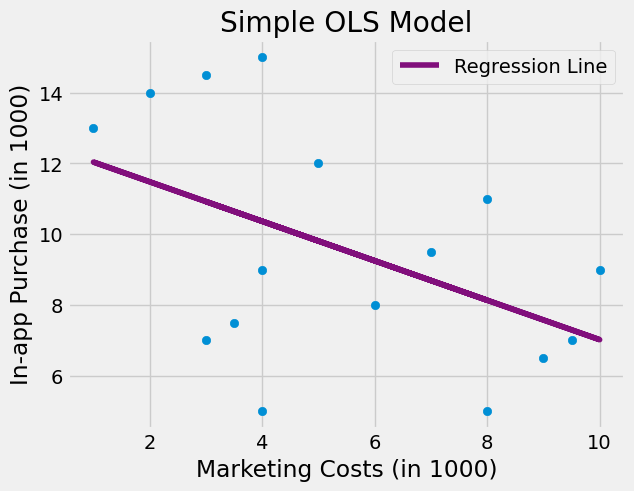

In [53]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend()
plt.show();

鉴于你在因果推断方面的丰富知识，你决定运行一个固定效应模型，将城市指标作为虚拟变量加入模型中。该固定效应模型控制了那些随时间不变的城市特定特征，因此如果某座城市对你的产品接受度较低，模型将捕捉到这一信息。当您运行该模型后，最终能够观察到更高的营销成本确实带来了应用内购买收入的提升。

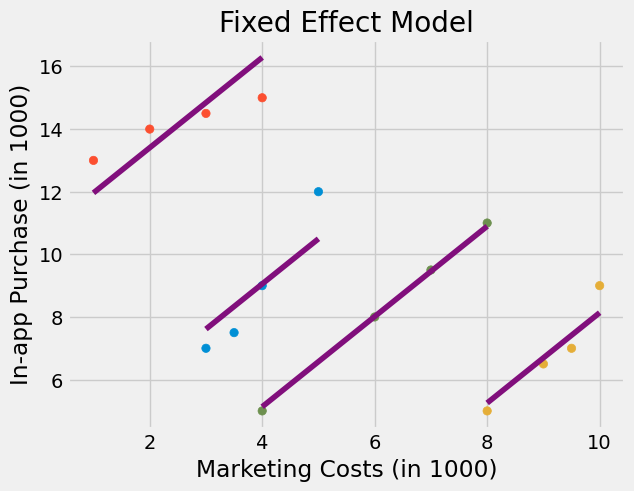

In [55]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.show();

花点时间理解上图向你展示的固定效应作用。你会发现，固定效应为每个城市拟合了一条回归线；而且这些线是平行的。线的斜率代表营销成本对应用内购买的影响。而固定效应模型假设因果效应在所有实体（本例中为城市）间是恒定的。这可以是一个优势，也可以是一个局限，取决于你的研究目的：

 - 如果你的目标是了解每个城市的因果效应是否不同，那么这就是一种限制，因为固定效应模型默认效应在城市之间不变，所以你无法识别这种差异；
 - 但如果你的目标是估计营销对整体应用内购买的平均影响，那么这种面板数据结构正是固定效应模型最能发挥作用的场景。

换句话说，固定效应模型牺牲了异质性（城市间效应的不同），换来了对个体固定特征的有效控制，这在因果推断中是非常有力的工具。


## 时间效应

正如我们在个体层面使用了固定效应一样，我们也可以对时间层面引入固定效应。

若为每个个体添加虚拟变量能控制个体固定特征，那么为时间添加虚拟变量则可控制那些在单个时间段内固定但可能随时间变化的变量。一个典型的例子就是通货膨胀。价格和工资往往随时间上涨，但每个时间段的通胀率对所有实体都是相同的。举个更具体的例子，假设结婚率随时间上升。若工资与结婚比例也随时间变化，时间就会成为混杂因素。由于通货膨胀同样导致工资随时间增长，我们观察到的婚姻与工资之间的正相关部分可能仅源于二者均随时间递增。为校正这一点，我们可为每个时间点添加虚拟变量。在 ``linear models`` 中，这只需将 ``TimeEffects`` 加入公式并将 ``cluster_time = True`` 即可实现。


In [13]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


在这个新模型中，婚姻对工资的影响从 ``0.1147`` 显著下降至 ``0.0476`` 。尽管如此，该结果在99%置信水平上仍具有统计显著性，因此男性仍可预期通过婚姻获得收入增长。

## 当面板数据无能为力时

使用面板数据和固定效应模型是进行因果推断的极其强大的工具。当你既没有随机数据也没有良好的工具变量时，固定效应对于非实验数据的因果推断来说是最具说服力的方法。然而，值得一提的是，它并非万能药。在某些情况下，即便是面板数据也无济于事。

最显而易见的情况是存在随时间变化的混淆变量。固定效应仅能消除个体属性中恒定的偏误。例如，假设通过阅读书籍和摄入大量优质脂肪可以提升智力水平，进而获得更高薪的工作并娶到妻子。由于此例中智力水平随时间变化，固定效应无法消除这种由未测量的智力混杂因素引起的偏误。

![img](./images/14/time-travel.png)

固定效应失效的另一种较不明显情形是存在反向因果关系。例如，假设并非婚姻导致收入增加，而是更高的收入提升了结婚概率。这种情况下二者会呈现正相关关系，但收入增长实为先行因素。二者随时间同向变动，因此固定效应无法对此进行控制。

## 核心要点

在本节中，我们探讨了如何使用面板数据——即对同一批个体在多个时间点进行多次测量的数据。当拥有此类数据时，可以使用固定效应模型，通过控制个体，将所有在时间上不变的个体特征保持固定。这种方法在控制混杂因素方面既强大又极具说服力，对于非随机数据而言已是最佳选择。

但最后我们也强调了：固定效应并不是万能的。它存在两种失效情形：一是存在反向因果关系时，二是未测量的混杂因素随时间变化时。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。